In [1]:
import backtrader as bt
import alpaca_backtrader_api as api
import alpaca_trade_api as tradeapi
import sys
sys.path.insert(0, '../')
import pandas as pd
import talib as ta
import numpy as np
from config import key_id, secret_key
from datetime import datetime 
from scipy import signal
import scipy
from pandas import DataFrame

In [2]:
#use modin for faster processing
#import modin.pandas as pd

In [3]:
data=pd.read_csv('data/JACK.csv')

In [4]:
type(data.index[0])

int

In [51]:
data2=data.set_index('timestamp').sort_index(ascending=False)

# Cleaning data


In [52]:
#converting timestamp row to timestamp type
data2.index=pd.to_datetime(data2.index, utc=True)

In [53]:
# Create a DatetimeIndex and assign it to the dataframe.
data2.index = pd.DatetimeIndex(data2.index)

In [54]:
#Count ticks on unique days
day_tick_cnt = data2.index.normalize() \
                     .value_counts() \
                     .to_frame().reset_index()

#Keep days that have ticks greater than 300
day_list=day_tick_cnt[~(day_tick_cnt['timestamp'] >= 240)]

In [55]:
len(day_tick_cnt)- len(day_list)

2690

In [56]:
#create date
data2['date']=data2.index.date

In [57]:
data2.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [58]:
#if date is in data, keep the data
cond= data2['date'].isin(day_list['index'])
data2.drop(data2[cond].index, inplace = True)

In [59]:
#data should now be cleaned of days where data is spotty
data2.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [60]:
#create time frame of opening to one hour before closing/ after hours
#data=pd.DataFrame.between_time(data,"14:30","20:00")

# Create Features
## Adding indicators

In [61]:
import talib.abstract as tab

In [140]:
#make sure to import these packages
from pandas import DataFrame
import talib.abstract as tab
#abstract automatically extracts the columns and periods from the data itself, no input required



#feel free to add or subtract more indicators for any other strategy you want to use
def populateindicators(dataframe) -> DataFrame:
        #make sure to remove these later
        #exponential moving averages
        dataframe['ema_high'] = tab.EMA(dataframe, timeperiod=5, price='high')
        dataframe['ema_close'] = tab.EMA(dataframe, timeperiod=5, price='close')
        dataframe['ema_low'] = tab.EMA(dataframe, timeperiod=5, price='low')
        dataframe['dema'] = ta.DEMA(dataframe['close'], timeperiod=30)
        
        #mathematics
        
        macd=tab.MACD(dataframe, fastperiod=12, slowperiod=26, signalperiod=9)
        dataframe['macd'] = macd['macd']
        dataframe['macdsignal']=macd['macdsignal']
        dataframe['macdhist']=macd['macdhist']
        
        
        #stochastics
        stoch_fast = tab.STOCHF(dataframe, 10.0, 3.0, 0.0, 3.0, 0.0)
        stoch= tab.STOCH(dataframe, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
        stoch_rsi=tab.STOCHRSI(dataframe, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
        
        
        dataframe['fastd'] = stoch['fastd']
        dataframe['fastk'] = stoch['fastk']
        
        dataframe['fastdf'] = stoch_fast['fastd']
        dataframe['fastkf'] = stoch_fast['fastk']
        
        dataframe['fastdrsi'] = stoch_rsi['fastd']
        dataframe['fastkrsi'] = stoch_rsi['fastk']
        
        
        
        dataframe['adx'] = tab.ADX(dataframe)
        dataframe['cci'] = tab.CCI(dataframe)
        dataframe['rsi2'] = tab.RSI(dataframe, timeperiod=14)
        
        #create time indicators
        dataframe['months']=dataframe.index.get_level_values(level='timestamp').month
        dataframe['dayofweek']=dataframe.index.get_level_values(level='timestamp').dayofweek
        dataframe['hourofday']=dataframe.index.get_level_values(level='timestamp').hour
        
        #create volume based indicators
        ta.ADOSC(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['close'], dtype='float'))

        
        #create row of labels/classification
        #if dataframe
            #dataframe['maxindex'] = tab.MAXINDEX(dataframe, timeperiod=30)
        
        
        
        
        return dataframe

In [142]:
tab.AD(data2)

Exception: volume is not double

In [153]:
#ta.ADOSC(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['close'], dtype='float'))  
attempt=ta.ADOSC(data2['high'], data2['low'], data2['close'], np.asarray(data2['close'], dtype='float')) 
attempt

timestamp
2020-04-09 16:10:00+00:00          NaN
2020-04-09 16:09:00+00:00          NaN
2020-04-09 16:08:00+00:00          NaN
2020-04-09 16:07:00+00:00          NaN
2020-04-09 16:06:00+00:00          NaN
                               ...    
2008-12-15 14:38:00+00:00    10.540935
2008-12-15 14:37:00+00:00     7.044292
2008-12-15 14:35:00+00:00     4.973456
2008-12-15 14:33:00+00:00     3.674164
2008-12-15 14:30:00+00:00     2.808620
Length: 911025, dtype: float64

In [63]:
# Compute RSI
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [64]:


def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band



In [65]:
data3=data2

In [68]:
data3.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [69]:
# Compute RSI
rsi_df = get_rsi(data3, window=14)
data3['rsi'] = pd.Series(data=rsi_df.values, index=data3.index)

# Drop the NaN values from our data set
data3.dropna(axis=0, how='any', inplace=True)



In [70]:
data3

,open,high,low,close,volume,date,rsi
timestamp,,,,,,,
2020-04-09 16:10:00+00:00,46.6500,46.6500,46.6500,46.6500,379,2020-04-09,23.0
2020-04-09 16:09:00+00:00,46.8400,46.8400,46.5400,46.8300,3111,2020-04-09,49.0
2020-04-09 16:08:00+00:00,46.7600,46.9000,46.7600,46.8500,3207,2020-04-09,55.0
2020-04-09 16:07:00+00:00,46.7500,46.7500,46.7500,46.7500,772,2020-04-09,54.0
2020-04-09 16:06:00+00:00,46.8000,46.8800,46.6700,46.6900,3853,2020-04-09,65.0
...,...,...,...,...,...,...,...
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15,22.0
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,48.0
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,72.0


In [71]:
# compute bands
window = 50
data3['avg'], data3['upper'], data3['lower'] = bbands(data3['close'], window, no_of_stdev=1.5)
data3.sample(10)

,open,high,low,close,volume,date,rsi,avg,upper,lower
timestamp,,,,,,,,,,
2020-02-05 16:12:00+00:00,83.420,83.485,83.42,83.4600,888,2020-02-05,40.0,83.714657,84.215570,83.213745
2020-02-25 15:55:00+00:00,84.190,84.200,84.19,84.2000,1065,2020-02-25,16.0,84.624127,85.070007,84.178246
2016-03-02 17:34:00+00:00,68.951,69.030,68.92,69.0300,4298,2016-03-02,33.0,69.144426,69.425798,68.863054
2010-01-19 19:24:00+00:00,20.560,20.560,20.55,20.5500,1892,2010-01-19,33.0,20.548069,20.608327,20.487810
2013-08-28 16:47:00+00:00,40.700,40.730,40.70,40.7000,1300,2013-08-28,56.0,40.703505,40.792329,40.614680
2017-01-24 16:06:00+00:00,107.720,107.800,107.72,107.7651,1537,2017-01-24,51.0,107.880117,108.224636,107.535598
2010-04-30 17:45:00+00:00,23.900,23.900,23.89,23.8900,600,2010-04-30,48.0,23.853871,23.929225,23.778518
2014-09-03 14:21:00+00:00,61.000,61.000,60.98,60.9800,1151,2014-09-03,80.0,60.709042,61.065419,60.352666
2017-09-25 17:33:00+00:00,97.110,97.110,97.02,97.0200,935,2017-09-25,59.0,96.952141,97.141861,96.762421


In [72]:
data3=populateindicators(data3).sort_index(ascending=True)

In [77]:
data4=data3.dropna()

In [78]:
data4

,open,high,low,close,volume,date,rsi,avg,upper,lower,...,macd,macdsignal,macdhist,fastd,fastk,adx,cci,months,dayofweek,hourofday
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15,35.0,20.260947,20.799372,19.722521,...,0.059307,0.061242,-0.001935,68.690440,10.102031,41.635909,-92.076452,12,0,14
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15,69.0,20.267516,20.814515,19.720517,...,0.099671,0.061725,0.037946,86.944718,95.969290,43.119032,139.920212,12,0,14
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,72.0,20.239659,20.755401,19.723918,...,0.063195,0.052239,0.010956,65.990991,100.000000,44.207774,187.515241,12,0,14
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,48.0,20.209037,20.680150,19.737925,...,0.011656,0.049500,-0.037844,32.657658,64.864865,45.085975,31.844487,12,0,14
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15,22.0,20.197978,20.671100,19.724855,...,-0.002378,0.058961,-0.061339,11.343728,33.108108,48.267869,-65.800610,12,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 15:06:00+00:00,46.1300,46.4100,46.0900,46.2700,1101,2020-04-09,62.0,46.247046,46.647580,45.846512,...,-0.006410,-0.060974,0.054564,69.890003,67.701863,24.341953,58.588297,4,3,15
2020-04-09 15:07:00+00:00,46.4100,46.4300,46.1600,46.2900,4893,2020-04-09,68.0,46.246023,46.655345,45.836702,...,-0.015845,-0.074614,0.058769,72.013006,70.366712,25.648485,81.994485,4,3,15
2020-04-09 15:08:00+00:00,46.2400,46.3000,46.2100,46.3000,1215,2020-04-09,62.0,46.244057,46.662215,45.825899,...,-0.029695,-0.089307,0.059612,69.390768,71.601432,26.654610,87.377199,4,3,15


# Machine Learning Setup

In [26]:
import mlfinlab as ml
import timeit


from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt



Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Triple Barrier labelling


In [79]:
#Read in data
data_ml=data4

In [80]:
data_ml

,open,high,low,close,volume,date,rsi,avg,upper,lower,...,macd,macdsignal,macdhist,fastd,fastk,adx,cci,months,dayofweek,hourofday
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15,35.0,20.260947,20.799372,19.722521,...,0.059307,0.061242,-0.001935,68.690440,10.102031,41.635909,-92.076452,12,0,14
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15,69.0,20.267516,20.814515,19.720517,...,0.099671,0.061725,0.037946,86.944718,95.969290,43.119032,139.920212,12,0,14
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,72.0,20.239659,20.755401,19.723918,...,0.063195,0.052239,0.010956,65.990991,100.000000,44.207774,187.515241,12,0,14
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,48.0,20.209037,20.680150,19.737925,...,0.011656,0.049500,-0.037844,32.657658,64.864865,45.085975,31.844487,12,0,14
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15,22.0,20.197978,20.671100,19.724855,...,-0.002378,0.058961,-0.061339,11.343728,33.108108,48.267869,-65.800610,12,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 15:06:00+00:00,46.1300,46.4100,46.0900,46.2700,1101,2020-04-09,62.0,46.247046,46.647580,45.846512,...,-0.006410,-0.060974,0.054564,69.890003,67.701863,24.341953,58.588297,4,3,15
2020-04-09 15:07:00+00:00,46.4100,46.4300,46.1600,46.2900,4893,2020-04-09,68.0,46.246023,46.655345,45.836702,...,-0.015845,-0.074614,0.058769,72.013006,70.366712,25.648485,81.994485,4,3,15
2020-04-09 15:08:00+00:00,46.2400,46.3000,46.2100,46.3000,1215,2020-04-09,62.0,46.244057,46.662215,45.825899,...,-0.029695,-0.089307,0.059612,69.390768,71.601432,26.654610,87.377199,4,3,15


### Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).


In [81]:
data_ml.head()

,open,high,low,close,volume,date,rsi,avg,upper,lower,...,macd,macdsignal,macdhist,fastd,fastk,adx,cci,months,dayofweek,hourofday
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15,35.0,20.260947,20.799372,19.722521,...,0.059307,0.061242,-0.001935,68.690440,10.102031,41.635909,-92.076452,12,0,14
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15,69.0,20.267516,20.814515,19.720517,...,0.099671,0.061725,0.037946,86.944718,95.969290,43.119032,139.920212,12,0,14
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,72.0,20.239659,20.755401,19.723918,...,0.063195,0.052239,0.010956,65.990991,100.000000,44.207774,187.515241,12,0,14
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,48.0,20.209037,20.680150,19.737925,...,0.011656,0.049500,-0.037844,32.657658,64.864865,45.085975,31.844487,12,0,14
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15,22.0,20.197978,20.671100,19.724855,...,-0.002378,0.058961,-0.061339,11.343728,33.108108,48.267869,-65.800610,12,0,14


## Fit a Primary Model: Bollinger Band Mean-Reversion

In [82]:
# Compute sides
#when above bb, is 1, when below is -1
data_ml['side'] = np.nan 
long_signals = (data_ml['close'] <= data_ml['lower']) 
short_signals = (data_ml['close'] >= data_ml['upper']) 

data_ml.loc[long_signals, 'side'] = 1
data_ml.loc[short_signals, 'side'] = -1

print(data_ml.side.value_counts())

# Remove Look ahead biase by lagging the signal
data_ml['side'] = data_ml['side'].shift(1)



 1.0    49589
-1.0    46938
Name: side, dtype: int64


C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [83]:
# Save the raw data
raw_data = data_ml.copy()

# Drop the NaN values from our data set
data_ml.dropna(axis=0, how='any', inplace=True)

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [84]:
data_ml

,open,high,low,close,volume,date,rsi,avg,upper,lower,...,macdsignal,macdhist,fastd,fastk,adx,cci,months,dayofweek,hourofday,side
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,72.0,20.239659,20.755401,19.723918,...,0.052239,0.010956,65.990991,100.000000,44.207774,187.515241,12,0,14,-1.0
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,48.0,20.209037,20.680150,19.737925,...,0.049500,-0.037844,32.657658,64.864865,45.085975,31.844487,12,0,14,-1.0
2008-12-15 14:50:00+00:00,20.5000,20.7400,20.5000,20.7300,500,2008-12-15,93.0,20.167039,20.683956,19.650122,...,0.122823,0.023154,98.809524,96.428571,64.611939,132.398656,12,0,14,-1.0
2008-12-15 14:51:00+00:00,20.6000,20.6000,20.5000,20.6000,2100,2008-12-15,88.0,20.144061,20.641251,19.646871,...,0.117035,0.016123,96.428571,100.000000,63.438948,88.911775,12,0,14,-1.0
2008-12-15 14:59:00+00:00,20.5300,20.5300,20.4700,20.4700,3000,2008-12-15,94.0,20.040718,20.486139,19.595297,...,0.085607,0.026173,95.517195,88.679245,60.816163,151.541219,12,0,14,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 14:48:00+00:00,47.0300,47.1400,46.8300,46.8900,3513,2020-04-09,71.0,46.354906,46.776461,45.933351,...,0.054648,0.014324,54.889371,78.070175,19.267644,168.240080,4,3,14,-1.0
2020-04-09 14:49:00+00:00,46.7500,46.7500,46.4000,46.4000,4226,2020-04-09,58.0,46.332138,46.727196,45.937080,...,0.051067,-0.020560,36.082474,41.237113,18.367909,19.356194,4,3,14,-1.0
2020-04-09 14:57:00+00:00,46.8400,46.8400,46.6000,46.7011,3041,2020-04-09,82.0,46.307796,46.699208,45.916384,...,0.038151,0.060735,85.899552,83.060976,22.033323,167.181228,4,3,14,-1.0


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [85]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data_ml['close'], lookback=50)


In [86]:
daily_vol

timestamp
2008-12-16 14:37:00+00:00         NaN
2008-12-16 14:38:00+00:00    0.023749
2008-12-16 14:39:00+00:00    0.019944
2008-12-16 14:43:00+00:00    0.018240
2008-12-16 14:45:00+00:00    0.017326
                               ...   
2020-04-09 14:48:00+00:00    0.037474
2020-04-09 14:49:00+00:00    0.036736
2020-04-09 14:57:00+00:00    0.036020
2020-04-09 14:58:00+00:00    0.035320
2020-04-09 14:59:00+00:00    0.034620
Name: close, Length: 96491, dtype: float64

In [87]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data_ml['close'], threshold=daily_vol['2009-01-01':'2020-01-01'].mean() * 0.1)

In [88]:
# Compute vertical barrier, gives the timestamps of when vertical barriers are crossed
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data_ml['close'], num_days=1)

In [89]:
vertical_barriers.head()

2008-12-15 14:37:00+00:00   2008-12-16 14:37:00+00:00
2008-12-15 14:50:00+00:00   2008-12-16 15:56:00+00:00
2008-12-15 14:51:00+00:00   2008-12-16 15:56:00+00:00
2008-12-15 14:59:00+00:00   2008-12-16 15:56:00+00:00
2008-12-15 15:02:00+00:00   2008-12-16 15:56:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [90]:
#ptsl=profit taking and/or stop loss
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data_ml['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=2,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data_ml['side'])

2020-04-14 10:51:58.581168 100.0% apply_pt_sl_on_t1 done after 0.96 minutes. Remaining 0.0 minutes.


In [91]:
labels = ml.labeling.get_bins(triple_barrier_events, data_ml['close'])
labels.side.value_counts()

 1.0    23876
-1.0    22857
Name: side, dtype: int64

## Results of Primary Model:

In [99]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16082
           1       0.66      1.00      0.79     30651

    accuracy                           0.66     46733
   macro avg       0.33      0.50      0.40     46733
weighted avg       0.43      0.66      0.52     46733

Confusion Matrix
[[    0 16082]
 [    0 30651]]

Accuracy
0.6558748635867588


C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 ###  Meta-labeling says that there aremany false-positives (50%) the sklearn's confusion matrix is [[TN, FP][FN, TP]]. however,  50% accuracy for a non metamodel is pretty good



# Fit a Meta Model

### Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

### Create the following features:
   - Volatility
   - Serial Correlation
   - The returns at the different lags from the serial correlation
   - The sides from the SMavg Strategy


In [100]:
raw_data.head()

,open,high,low,close,volume,date,rsi,avg,upper,lower,...,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,fast_mavg,slow_mavg,sma
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15,35.0,20.260947,20.799372,19.722521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15,69.0,20.267516,20.814515,19.720517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,72.0,20.239659,20.755401,19.723918,...,NaN,NaN,0.041419,NaN,NaN,NaN,NaN,NaN,NaN,0
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,48.0,20.209037,20.680150,19.737925,...,NaN,NaN,0.001903,0.041419,NaN,NaN,NaN,NaN,NaN,0
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15,22.0,20.197978,20.671100,19.724855,...,NaN,NaN,-0.024593,0.001903,0.041419,NaN,NaN,NaN,NaN,0


In [101]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

KeyboardInterrupt: 

In [102]:
# Add Trending signals
raw_data['sma'] = 0

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [103]:
# Re compute sides
raw_data['side'] = 0

long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [104]:
# Remove look ahead bias
raw_data_shifted = raw_data.shift(1)

In [105]:
raw_data_shifted.columns

Index(['open', 'high', 'low', 'close', 'volume', 'date', 'rsi', 'avg', 'upper',
       'lower', 'ema_high', 'ema_close', 'ema_low', 'dema', 'macd',
       'macdsignal', 'macdhist', 'fastd', 'fastk', 'adx', 'cci', 'months',
       'dayofweek', 'hourofday', 'side', 'log_ret', 'mom1', 'mom2', 'mom3',
       'mom4', 'mom5', 'volatility', 'autocorr_1', 'autocorr_2', 'autocorr_3',
       'autocorr_4', 'autocorr_5', 'log_t1', 'log_t2', 'log_t3', 'log_t4',
       'log_t5', 'fast_mavg', 'slow_mavg', 'sma'],
      dtype='object')

In [124]:
#make sure to drop all
# Get features at event dates
X = raw_data_shifted.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low' ,'close','volume','date','ema_high','ema_low','ema_close', 'dema', 'lower', 'upper',   'close',  \
        'avg', 'fast_mavg', 'slow_mavg'], axis=1, inplace=True)
#'macd','macdsignal','macdhist',
#,'months','dayofweek','hourofday'
y = labels['bin'].dropna()
X

,rsi,macd,macdsignal,macdhist,fastd,fastk,adx,cci,months,dayofweek,...,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,sma
2008-12-16 14:38:00+00:00,25.0,-0.063296,-0.026106,-0.037190,11.930926,0.000000,18.719445,-188.430947,12.0,1.0,...,0.274786,-0.087287,0.013320,0.024405,-0.000513,0.003596,0.016083,-0.041993,0.043563,1.0
2008-12-16 14:39:00+00:00,33.0,-0.039712,-0.016808,-0.022904,24.515960,15.384615,17.455388,-122.621902,12.0,1.0,...,0.270592,-0.079619,0.044476,-0.066972,0.009193,-0.000513,0.003596,0.016083,-0.041993,1.0
2008-12-16 14:43:00+00:00,34.0,-0.021342,0.003060,-0.024402,9.795322,8.333333,19.612467,-201.853540,12.0,1.0,...,0.268013,-0.076803,0.027525,-0.070101,0.000250,0.004256,0.002512,0.010620,0.009193,1.0
2008-12-16 14:45:00+00:00,50.0,0.000424,0.012839,-0.012414,9.195402,0.000000,20.832183,-129.899410,12.0,1.0,...,0.272862,-0.074867,0.027365,-0.056320,0.007018,-0.007018,0.000250,0.004256,0.002512,1.0
2008-12-16 15:56:00+00:00,6.0,-0.070211,-0.055482,-0.014729,19.824017,28.571429,71.438278,-94.560290,12.0,1.0,...,0.047320,-0.150991,-0.019270,0.041524,-0.000499,-0.001995,-0.002488,0.004483,0.000999,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-07 17:38:00+00:00,83.0,0.216146,0.158996,0.057149,89.252318,98.734177,20.343265,177.764952,4.0,1.0,...,0.187068,-0.166428,-0.102245,-0.149554,0.000246,0.001108,-0.001831,-0.002470,-0.000490,1.0
2020-04-07 17:39:00+00:00,83.0,0.186445,0.144709,0.041736,71.896481,80.432173,18.264025,213.096436,4.0,1.0,...,0.169599,-0.149156,-0.081166,-0.090424,0.000492,0.000246,0.001108,-0.001831,-0.002470,1.0
2020-04-07 17:40:00+00:00,80.0,0.163133,0.134275,0.028857,72.614742,88.590604,16.072049,225.642236,4.0,1.0,...,0.143801,-0.148157,-0.116406,-0.062518,-0.004188,0.000492,0.000246,0.001108,-0.001831,1.0
2020-04-08 13:30:00+00:00,35.0,-0.335562,-0.275858,-0.059704,52.049170,0.000000,18.029022,-165.247334,4.0,1.0,...,-0.220313,0.090896,0.018997,-0.186891,0.002245,-0.007465,0.000868,0.002235,-0.008740,1.0


In [125]:
y

2008-12-16 14:38:00+00:00    1
2008-12-16 14:39:00+00:00    1
2008-12-16 14:43:00+00:00    1
2008-12-16 14:45:00+00:00    1
2008-12-16 15:56:00+00:00    1
                            ..
2020-04-07 17:38:00+00:00    0
2020-04-07 17:39:00+00:00    0
2020-04-07 17:40:00+00:00    0
2020-04-08 13:30:00+00:00    1
2020-04-08 13:38:00+00:00    1
Name: bin, Length: 46733, dtype: int64

In [126]:
X.columns

Index(['rsi', 'macd', 'macdsignal', 'macdhist', 'fastd', 'fastk', 'adx', 'cci',
       'months', 'dayofweek', 'hourofday', 'side', 'log_ret', 'mom1', 'mom2',
       'mom3', 'mom4', 'mom5', 'volatility', 'autocorr_1', 'autocorr_2',
       'autocorr_3', 'autocorr_4', 'autocorr_5', 'log_t1', 'log_t2', 'log_t3',
       'log_t4', 'log_t5', 'sma'],
      dtype='object')

### Fit a model

In [127]:
# Split data into training, validation and test sets
X_training_validation = X['2009-01-01':'2020-01-01']
y_training_validation = y['2009-01-01':'2020-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.1, shuffle=False)

In [128]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

1    26580
0    14029
Name: bin, dtype: int64

In [129]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    14029
0    14029
Name: bin, dtype: int64

In [130]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [131]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [132]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=7, n_estimators=512,
                            criterion='entropy', random_state=42)
rf.fit(X_train, y_train.values.ravel())



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=512,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [133]:
#XGBOOSt model
#Creating the Model

import xgboost as xgb
from xgboost.sklearn import XGBRFClassifier
from xgboost.sklearn import XGBRFRegressor
from xgboost.sklearn import XGBRegressor

model = XGBRFClassifier(nthread=12, max_depth=7, n_estimators=512) #nthreads allows more core usage


In [134]:
 model.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=512, n_jobs=1,
              nthread=12, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [135]:
y_pred = model.predict(X_validate)

In [136]:
from sklearn.metrics import accuracy_score

# evaluate predictions
accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.40%


## Training Metrics

              precision    recall  f1-score   support

           0       0.62      0.69      0.65     14029
           1       0.65      0.57      0.61     14029

    accuracy                           0.63     28058
   macro avg       0.63      0.63      0.63     28058
weighted avg       0.63      0.63      0.63     28058

Confusion Matrix
[[9732 4297]
 [6041 7988]]

Accuracy
0.6315489343502745


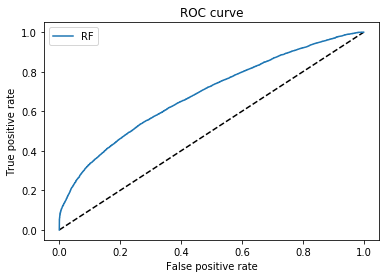

In [137]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Validation Metrics

              precision    recall  f1-score   support

           0       0.40      0.56      0.47      1502
           1       0.73      0.58      0.65      3011

    accuracy                           0.57      4513
   macro avg       0.56      0.57      0.56      4513
weighted avg       0.62      0.57      0.59      4513

Confusion Matrix
[[ 838  664]
 [1259 1752]]

Accuracy
0.573897629071571


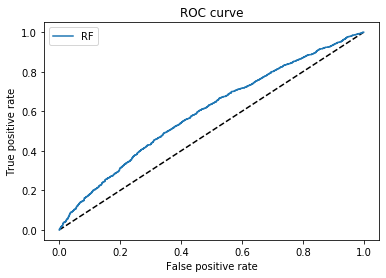

In [138]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [117]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2016-08-01 10:31:44.455000')
end = primary_forecast.index.get_loc('2017-12-29 21:03:37.018000') + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

KeyError: '2016-08-01 10:31:44.455000'

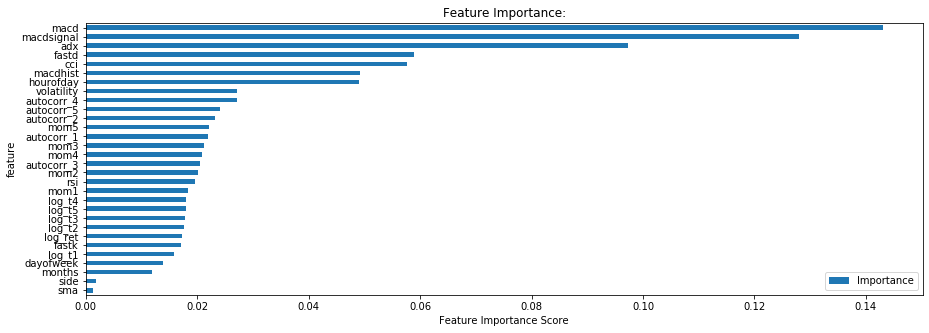

In [139]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

# Performance Tear Sheets (In-sample)

In [60]:
import pyfolio as pf

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [61]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [62]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [71]:


test_dates = X_validate.index

base_rets = labels.loc[test_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(primary_model_rets)
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets)



TypeError: show_perf_stats() missing 1 required positional argument: 'factor_returns'

In [ ]:
#save the data as a new 

In [ ]:
.to_pickle